## Phase 3.31
# Support Vector Machines

## Objectives
- <a href='#intro'>Introduction</a> to Support Vector Machines.
- Walk through the way SVCs create <a href='#visual'>decision boundaries</a>.
- Look at the difference between <a href='#lin_rbf'>Linear and RBF</a> kernels.
- Discuss the <a href='#pros_cons'>pros and cons</a> for this algorithm.

<a id='intro'></a>
# Introduction
> A Support Vector Machine (SVM) is a type of classifier which **modifies the loss function** for optimization to not only take into account overall accuracy metrics of the resulting predictions, but **also to maximize the decision boundary** between the data points. In essence, this further helps tune the classifier as a good balance between underfitting and overfitting.

# Visual Walkthrough
## Basic Example
1. Two Classes
<img src='./images/svm1.png' width='300'>

2. Maximize the boundary between classes.
<img src='./images/svm2.png' width='300'>

***Simple Enough!*** *The detailed mathematics can be found in the curriculum.*

## C-Value - (***Strength of the magnet***)

- **Left:** A *large* value for $C$. 
    - Misclassifications are heavily punished.
        - Optimization prioritizes correct predictions over **size of margin**.
        
- **Right:** A *small* value for $C$.
    - The largest possible margin is achieved, even at the expense of some misclassifications.
        - A more generalized model is created.
        - Helps with **overfitting**.
    
<img src='./images/svm3.png' width='600'>

- The middle line is the *decision barrier* (hyperplane): 
    - Where the classification prediction "flips" from one to the other.
- The outer lines are lines drawn based on the *support vectors*: 
    - Data points that are closer to the decision barrier and influence the position and orientation of the barrier.

<a id='visual'></a>
# Playing with Decision Boundaries (Hyperplanes)

In [1]:
from sklearn.datasets import make_blobs

from sklearn.svm import SVC

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Setting style.
plt.style.use(['ggplot', 'seaborn-talk'])

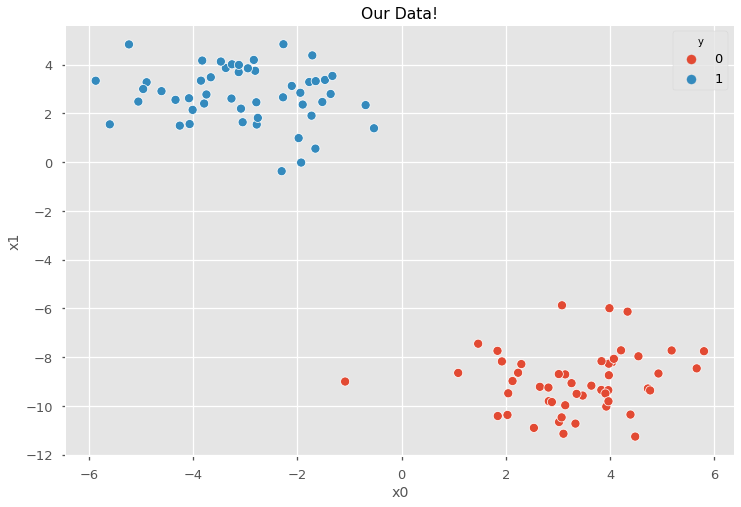

In [3]:
# Make some simple data to look at.
X, y = make_blobs(
    n_features=2, 
    centers=2, 
    cluster_std=1.25, 
    random_state=51)

# Transform to df for easy plotting.
df = pd.DataFrame(X, columns=['x0', 'x1'])
df['y'] = y

# Plot data.
fig, ax = plt.subplots()
sns.scatterplot(x='x0', y='x1', hue='y', data=df, ax=ax)
ax.set(title='Our Data!')
fig.tight_layout()

In [4]:
# Train a SVC on the data.
svc = SVC(kernel='linear')
svc.fit(X, y)

SVC(kernel='linear')

In [5]:
# Coordinates of the points that determine the decision boundary.
svc.support_vectors_

array([[ 3.07585619, -5.87025641],
       [-1.08438573, -8.99719307],
       [-2.30168734, -0.37109102]])

In [6]:
# Function to find where the predictions change.
def get_decision_barrier(X, svc):
    """Returns the coordinates where the predictions flip."""
    
    X0_vals = np.arange(min(X[:,0].flatten()), max(X[:,0].flatten()), 0.1)
    X1_vals = np.arange(min(X[:,1].flatten()), max(X[:,1].flatten()), 0.1)

    # Iterate through coordinates to find the decision barrier.
    barrier_lst = [] # coordinates where the prediction changes from one to the next.
    for x0 in X0_vals:
        last_pred = None

        for x1 in X1_vals:
            curr_pred = svc.predict(np.array([[x0, x1]]))

            if last_pred is None: # Checking if this is the first point in the iteration.
                last_pred = curr_pred

            if curr_pred != last_pred:
                barrier_lst.append((x0, x1)) # Append the coordinate where the prediction changes.

            last_pred = curr_pred

    barrier_lst = np.array(barrier_lst)
    return barrier_lst

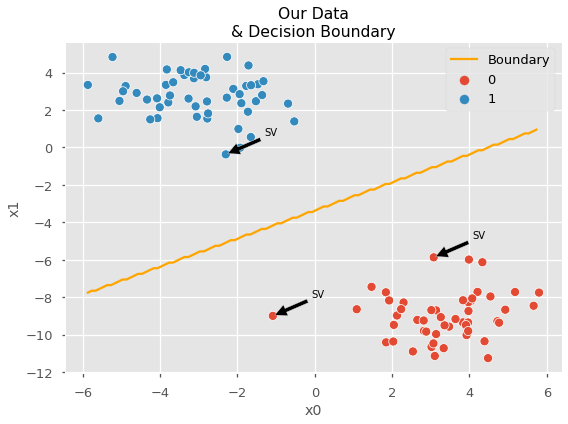

In [7]:
# Show the decision boundary.
barrier_lst = get_decision_barrier(X, svc)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x='x0', y='x1', hue='y', data=df, ax=ax)
ax.plot(barrier_lst[:,0], barrier_lst[:,1], color='orange', label='Boundary')

# Show Support Vectors (points from which the boundaries are drawn).
for sv_x, sv_y in svc.support_vectors_:
    ax.annotate(
        'SV', xy=(sv_x, sv_y), xytext=(sv_x+1, sv_y+1),
        arrowprops=dict(facecolor='black', shrink=0.05))

ax.set(title='Our Data\n& Decision Boundary')
ax.legend()
fig.tight_layout()

<a id='lin_rbf'></a>
# Linear vs RBF
- There are two main types of SVC kernel - Linear and Radial Basis Function (RBF).
    - Linear SVCs use a linear decision boundary to separate classes.
    - RBF SVCs use a decision boundary which radiates from certain points in the vector space.


> *Visualization Inspiration*: 
- https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py

In [8]:
from sklearn.datasets import make_classification, make_moons, make_circles

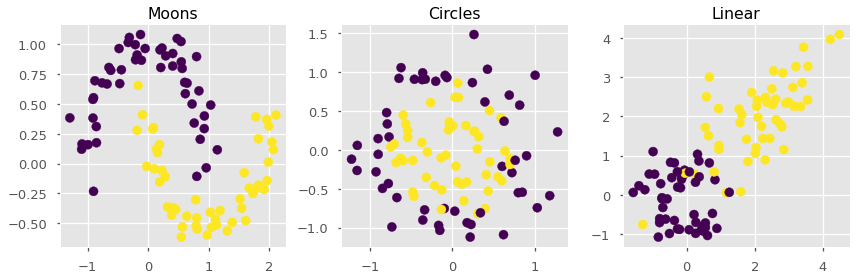

In [9]:
# Make datasets.
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2,
    random_state=51, n_clusters_per_class=1)
rng = np.random.RandomState(51)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    ('Moons', make_moons(noise=0.1, random_state=51)),
    ('Circles', make_circles(noise=0.2, factor=0.5, random_state=51)),
    ('Linear', linearly_separable)
]

# Plot data.
fig, ax_lst = plt.subplots(ncols=3, figsize=(12,4))
for (title, data), ax in zip(datasets, ax_lst):
    X, y = data
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    ax.set(title=title)
fig.tight_layout()

In [10]:
def plot_on_meshgrid(datasets, classifiers, H=0.02, SQ_SIZE=4, plot_sv=True):
    """
    Datasets: list of tuples: (`title`, (X, y))
    Classifiers: list of tuples: (`name`, `unfit_clf`)
    H: default: 0.02: Step size to take in the meshgrid.
    SQ_SIZE: Int: Size of individual subplots.
    
    If `plot_sv`, the support vectors and decision boundaries will be outlined.
    """
    
    # Setting subplot specs.
    ROWS = len(classifiers)
    COLS = len(datasets)
    FIGSIZE = (COLS*SQ_SIZE, ROWS*SQ_SIZE)
    
    # Iterate and plot the model's interaction with the dataset.
    fig, ax_lst = plt.subplots(nrows=ROWS, ncols=COLS, figsize=FIGSIZE)
    for n_dataset, (data_title, data) in enumerate(datasets):
        for n_classifier, (ax, (name, clf)) in \
                enumerate(zip(ax_lst[:, n_dataset], classifiers)):
            # Process data.
            X, y = data
            x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
            y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
            xx, yy = np.meshgrid(np.arange(x_min, x_max, H),
                                 np.arange(y_min, y_max, H))

            # Fit model.
            clf.fit(X, y)

            # Plot the decision function (class probabilities).
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap='viridis', alpha=.8)
            
            # Plot the decision boundaries and support vectors.
            if plot_sv:
                ax.contour(
                    xx, yy, Z, 
                    colors=['red', 'blue', 'red'], 
                    levels=[-1, 0, 1], 
                    linestyles=[':', '-', ':']
                    )

            # Plot the data.
            ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            ax.set_xticks(())
            ax.set_yticks(())
            
            # We want to label the rows and columns once only.
            # (Leftmost and uppermost)
            if n_dataset == 0:
                ax.set(ylabel=f'{name} - $C$={clf.C}')
            if n_classifier == 0:
                ax.set(title=data_title)
    fig.tight_layout()
    plt.show()

## Linear

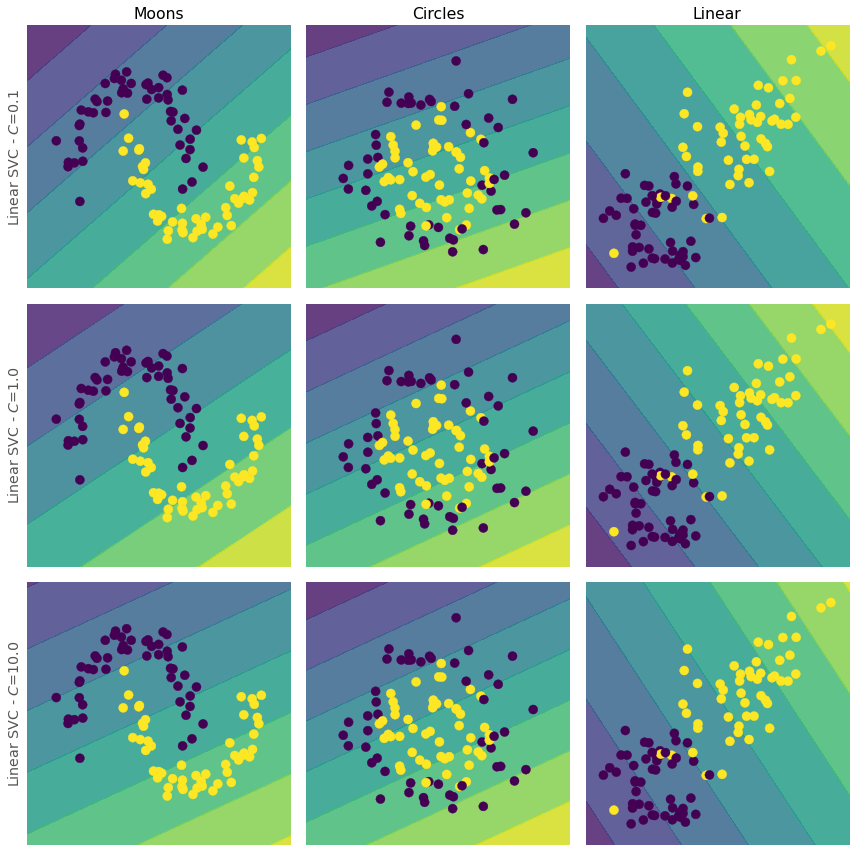

In [11]:
linear_classifiers = [
    ('Linear SVC', SVC(kernel="linear", C=0.1)),
    ('Linear SVC', SVC(kernel="linear", C=1.0)),
    ('Linear SVC', SVC(kernel="linear", C=10.0))
]

# Plot decsion_function.
plot_on_meshgrid(datasets, linear_classifiers, plot_sv=False)

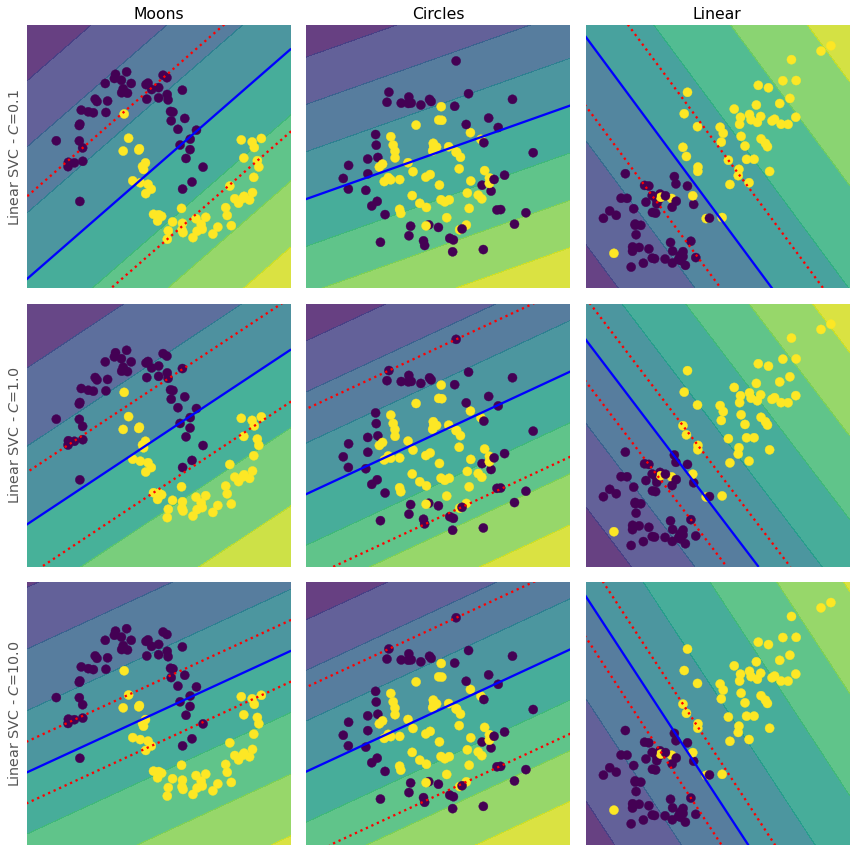

In [12]:
# Plot decision function *with support vectors.
plot_on_meshgrid(datasets, linear_classifiers, plot_sv=True)

In [13]:
# # Testing with a new random dataset which will have different outliers.
# X_new, y_new = make_classification(
#     n_features=2, n_redundant=0, n_informative=2,
#     random_state=42, n_clusters_per_class=1)
# rng = np.random.RandomState(2021)
# X_new += 2 * rng.uniform(size=X_new.shape)
# linearly_separable_new = (X_new, y_new)

In [14]:
# plot_on_meshgrid(
#     datasets+[('New Data', linearly_separable_new)], 
#     linear_classifiers, plot_sv=True
#     )

## RBF

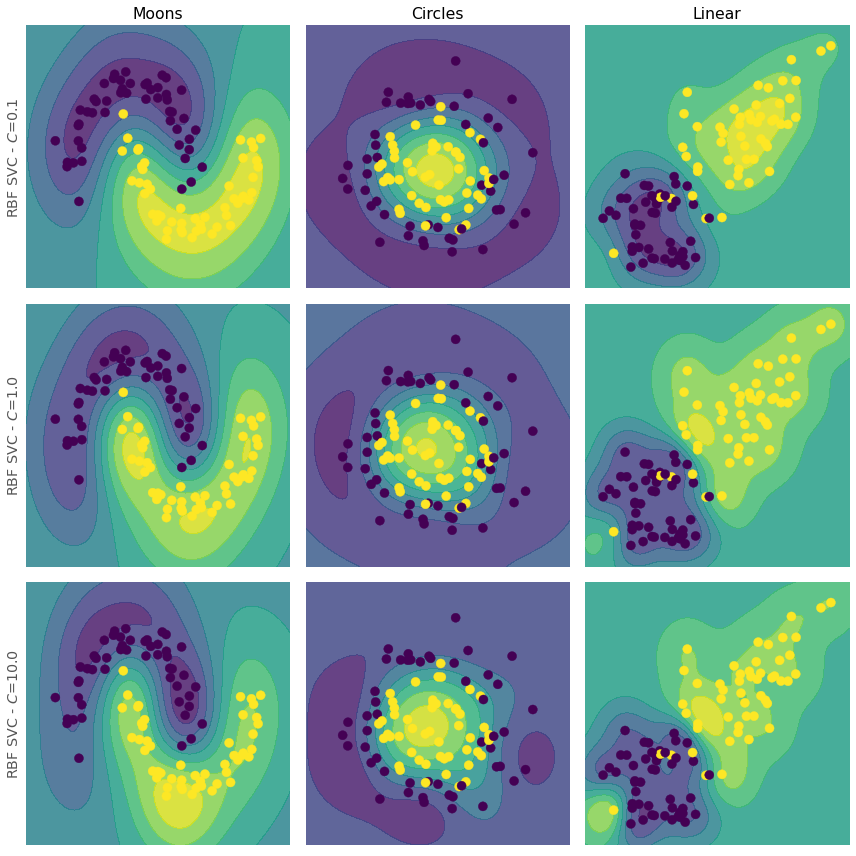

In [15]:
rbf_classifiers = [
    ('RBF SVC', SVC(gamma=2, C=0.1)),
    ('RBF SVC', SVC(gamma=2, C=1.0)),
    ('RBF SVC', SVC(gamma=2, C=10.0))
]

# Plot decision function.
plot_on_meshgrid(datasets, rbf_classifiers, plot_sv=False)

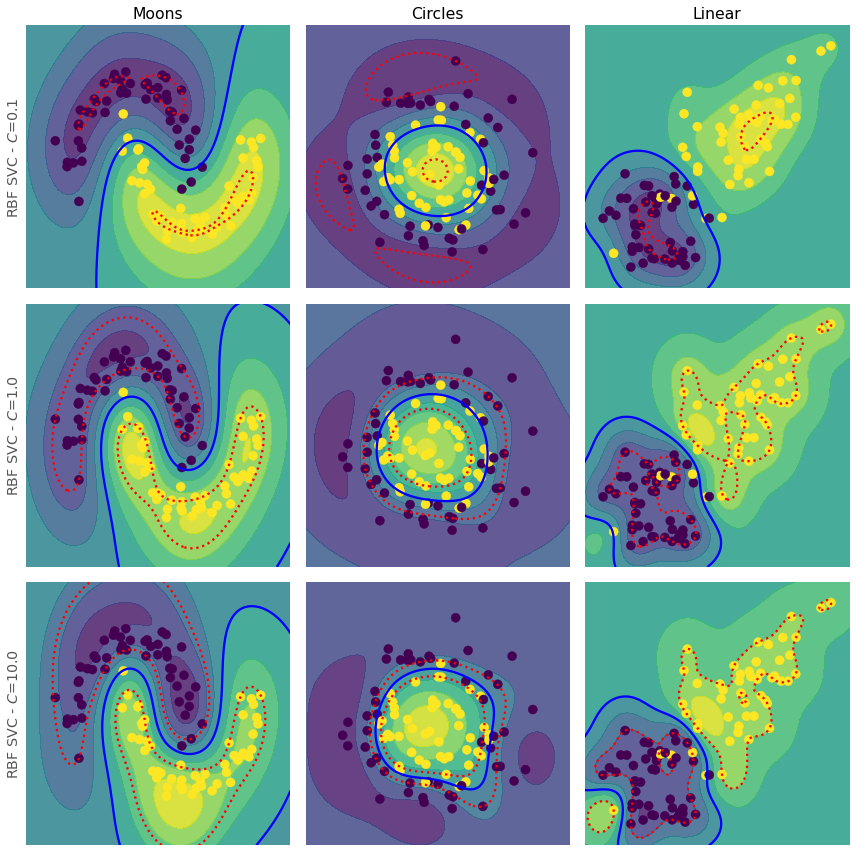

In [16]:
# Add support vectors.
plot_on_meshgrid(datasets, rbf_classifiers, plot_sv=True)

<a id='pros_cons'></a>
# Pros-Cons
## Pros
- No assumptions!
- Good for datasets with high dimensionality.
- Very good performance.
    - Can approximate complex non-linear functions.

## Cons
- Long training time.
- Lots of tuning required. (`Kernel` & `C` especially)